# Clasificación con SVM

| Nº | Columna                    | Tipo               | Descripción                                                                     |
| -- | -------------------------- | ------------------ | ------------------------------------------------------------------------------- |
| 1  | `Pregnancies`              | Numérico           | Número de embarazos que ha tenido la paciente.                                  |
| 2  | `Glucose`                  | Numérico           | Nivel de glucosa en sangre en una prueba de tolerancia a la glucosa.            |
| 3  | `BloodPressure`            | Numérico           | Presión arterial diastólica (mm Hg).                                            |
| 4  | `SkinThickness`            | Numérico           | Grosor del pliegue cutáneo del tríceps (mm), usado para estimar grasa corporal. |
| 5  | `Insulin`                  | Numérico           | Nivel de insulina sérica (mu U/ml).                                             |
| 6  | `BMI`                      | Numérico           | Índice de masa corporal: peso en kg / (altura en m)^2.                          |
| 7  | `DiabetesPedigreeFunction` | Numérico           | Función de antecedentes genéticos de diabetes (influencia hereditaria).         |
| 8  | `Age`                      | Numérico           | Edad del paciente (en años).                                                    |
| 9  | `Outcome`                  | Categórica (0 o 1) | Variable objetivo: 1 si la persona tiene diabetes, 0 si no.                     |


Dependencias

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.decomposition import PCA

1. Cargar datos

In [30]:
df = pd.read_csv("../../datasets/diabetes/pima-indians-diabetes.csv", header=0)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


 3. Análisis Exploratorio (EDA)

In [31]:
print("Primeras filas:")
print(df.head())

Primeras filas:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [32]:
print("\nInformación general:")
print(df.info())


Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [33]:
print("\nEstadísticas:")
print(df.describe())


Estadísticas:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000   

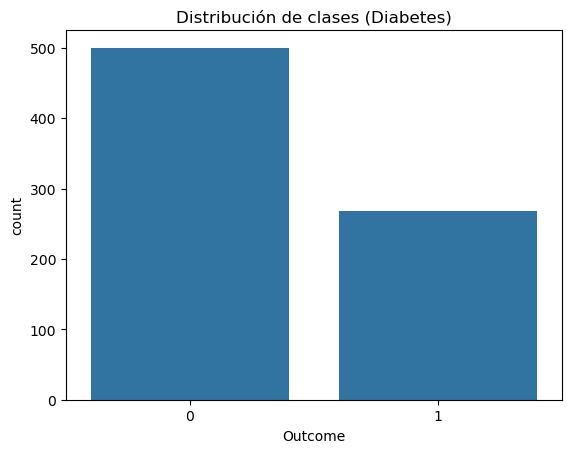

In [34]:
# Distribución del objetivo
sns.countplot(x='Outcome', data=df)
plt.title("Distribución de clases (Diabetes)")
plt.show()

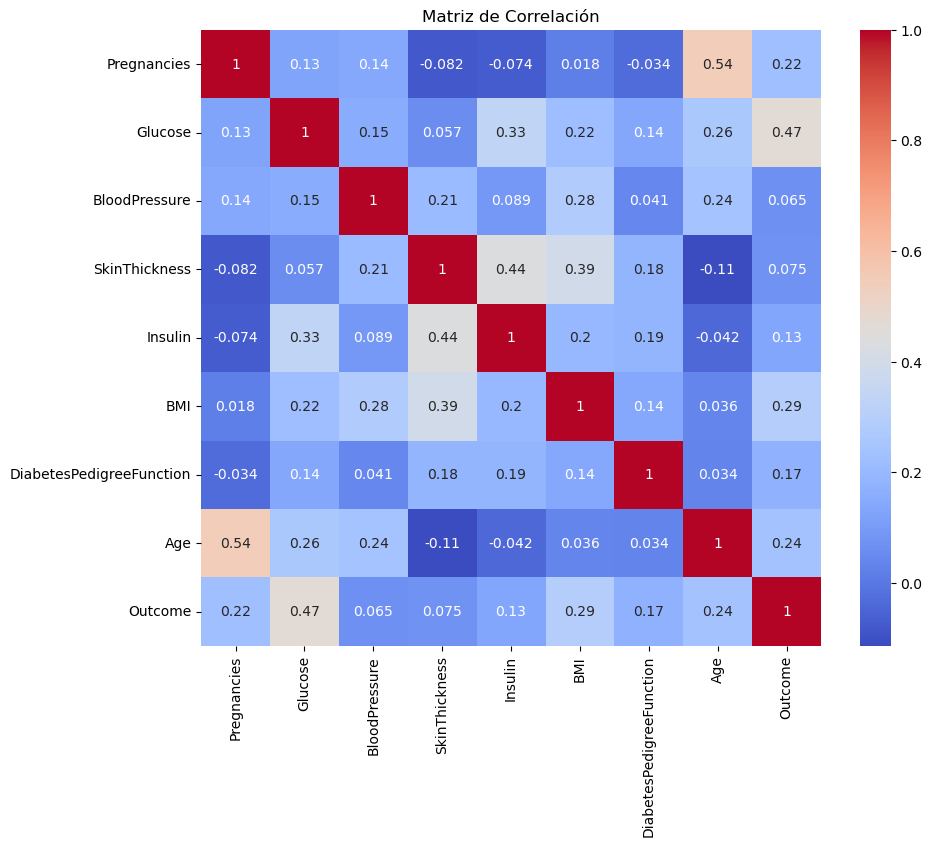

In [35]:
# Correlación
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()

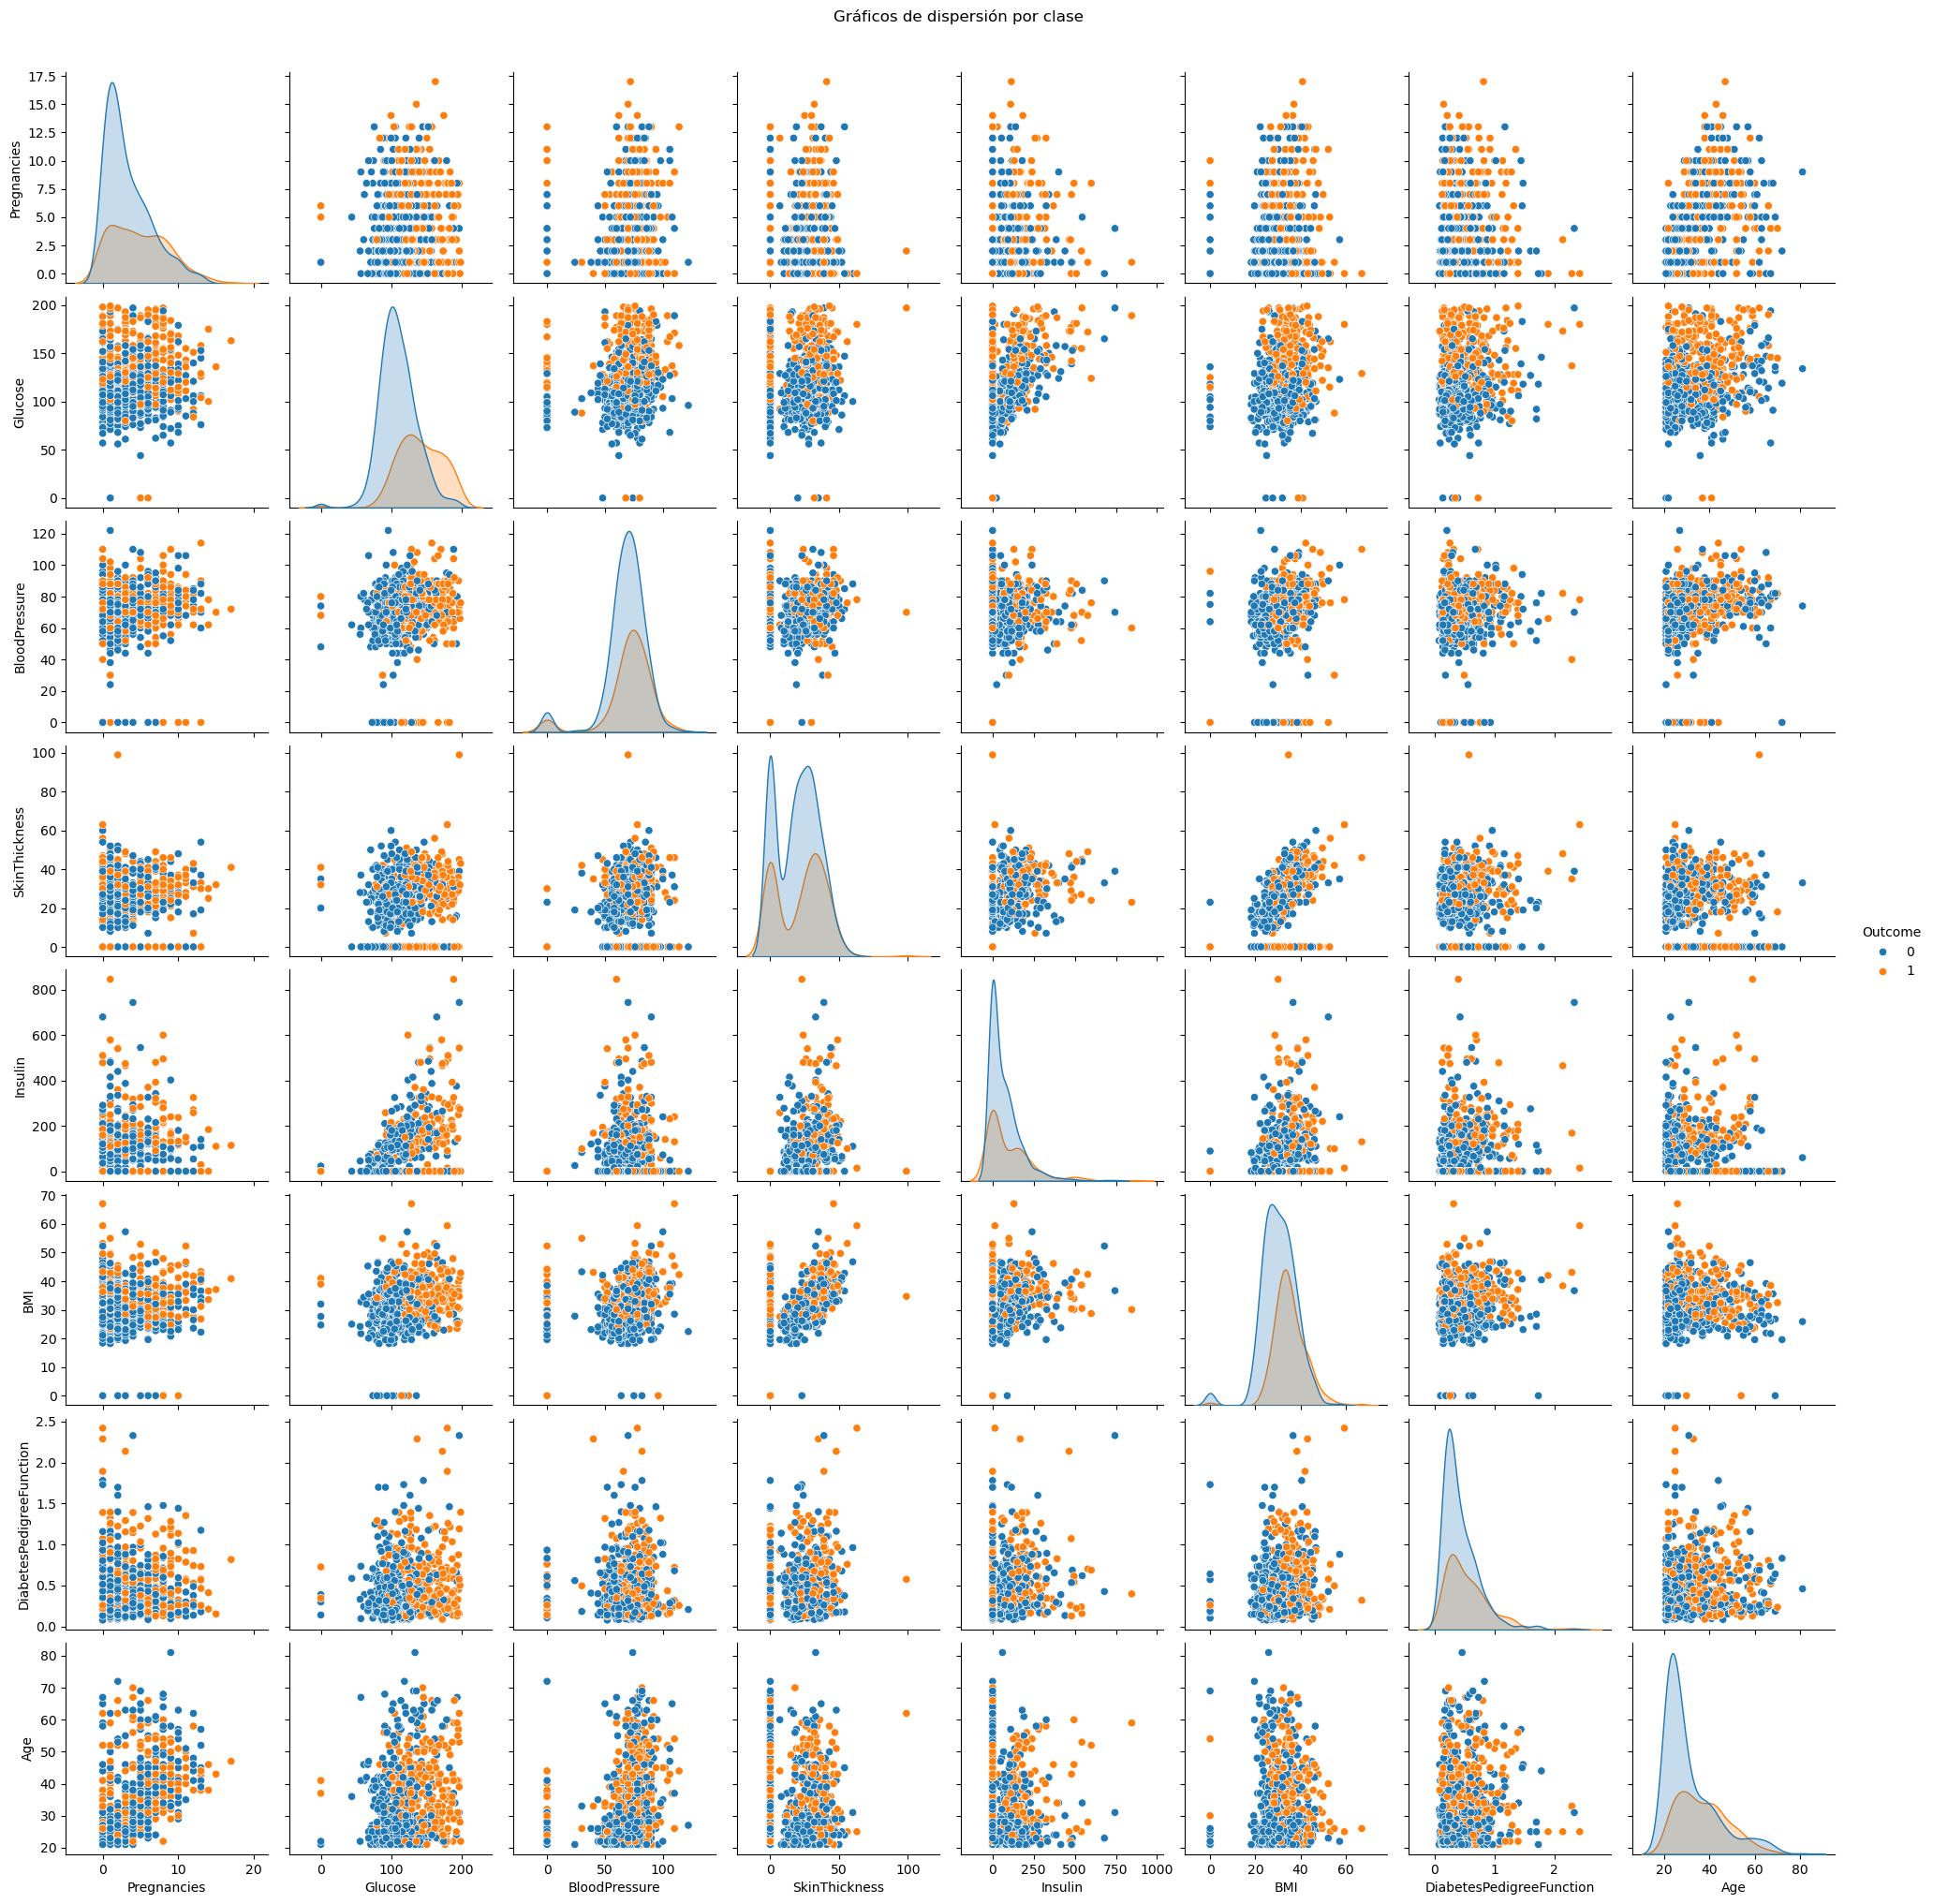

In [36]:
sns.pairplot(df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']], hue='Outcome')
plt.suptitle("Gráficos de dispersión por clase", y=1.02)
plt.show()

3. Limpieza y tratamiento de nulos

In [37]:
# Reemplazar ceros por NaN en columnas que no deberían tener cero
cols_with_zero_as_nan = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zero_as_nan] = df[cols_with_zero_as_nan].replace(0, np.nan)

In [38]:
# Imputación con la mediana
imputer = SimpleImputer(strategy='median')
df[cols_with_zero_as_nan] = imputer.fit_transform(df[cols_with_zero_as_nan])

In [39]:
print("\nValores nulos después de imputación:")
print(df.isnull().sum())


Valores nulos después de imputación:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


4. Transformación de variables

Separación de variables

In [40]:
X = df.drop(columns=['Outcome'])
y = df['Outcome']

Escalado

In [41]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Separación del conjunto de datos

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

5. Entrenamiento y validación del modelo

Modelo

In [43]:
param_grid = {
    'C': [0.1, 1, 10, 100],         # penalización
    'gamma': [1, 0.1, 0.01, 0.001], # coeficiente del kernel RBF
    'kernel': ['linear']               # kernel radial (más común)
}


In [44]:
clf = SVC(probability=True)

In [45]:
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)

In [46]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear']},
             scoring='roc_auc', verbose=1)

Evaluación del modelo

In [47]:
best_svm = grid_search.best_estimator_

y_pred = best_svm.predict(X_test)
y_proba = best_svm.predict_proba(X_test)[:, 1]

In [48]:
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

Mejores parámetros encontrados:
{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}


In [49]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.87      0.80       150
           1       0.66      0.47      0.55        81

    accuracy                           0.73       231
   macro avg       0.70      0.67      0.68       231
weighted avg       0.72      0.73      0.71       231



In [50]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[130  20]
 [ 43  38]]


In [51]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Accuracy: 0.7272727272727273
ROC AUC: 0.8320987654320988


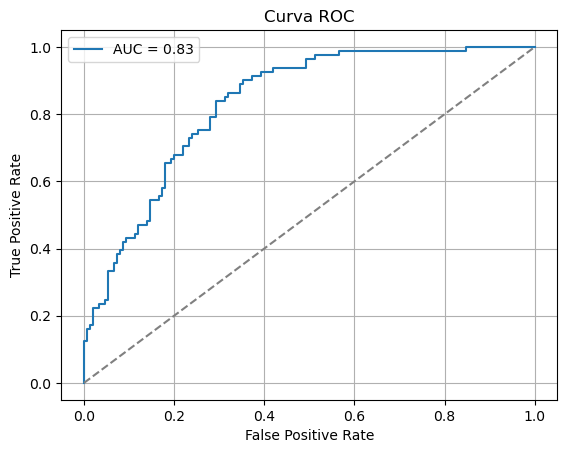

In [52]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.show()

In [53]:
w = best_svm.coef_[0]      # coeficientes del hiperplano
b = best_svm.intercept_[0] # sesgo

In [54]:
print("Coeficientes del hiperplano:", w)
print("Sesgo:", b)

Coeficientes del hiperplano: [ 0.40273189  0.89280574 -0.02606265 -0.10503212  0.01229209  0.51981519
  0.16874018 -0.01595097]
Sesgo: -0.7253057311007791


In [70]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pca

array([[ 1.44948091,  0.65976875],
       [-1.49883475, -0.07604933],
       [ 0.42324603,  0.76132708],
       ...,
       [-0.87570123,  0.88805999],
       [-0.38529482,  0.23126666],
       [-1.22969382, -0.65397214]])

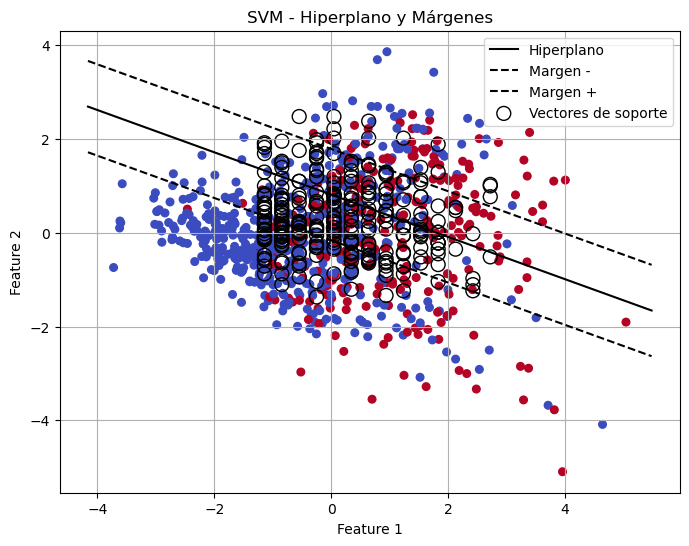

In [71]:

# Ecuación del hiperplano: w0*x + w1*y + b = 0
# => y = -(w0/w1)*x - b/w1

# ========================
# 4. Crear la malla para graficar
# ========================
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', s=30)

# Límites
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Crear la grilla
xx = np.linspace(xlim[0], xlim[1])
yy = -(w[0] / w[1]) * xx - b / w[1]

# Márgenes
margin = 1 / np.sqrt(np.sum(best_svm.coef_ ** 2))
yy_down = yy - np.sqrt(1 + (w[0] / w[1]) ** 2) * margin
yy_up = yy + np.sqrt(1 + (w[0] / w[1]) ** 2) * margin

# ========================
# 5. Dibujar las líneas
# ========================
plt.plot(xx, yy, 'k-', label='Hiperplano')
plt.plot(xx, yy_down, 'k--', label='Margen -')
plt.plot(xx, yy_up, 'k--', label='Margen +')

# Dibujar vectores de soporte
plt.scatter(best_svm.support_vectors_[:, 0], best_svm.support_vectors_[:, 1],
            s=100, facecolors='none', edgecolors='k', label='Vectores de soporte')

plt.legend()
plt.title("SVM - Hiperplano y Márgenes")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()